<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W2D1_BayesianStatistics/student/W2D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 1, Tutorial 3:
# Fitting to data

__Content creators:__ Vincent Valton, Konrad Kording

__Content reviewers:__ Matt Krause, Jesse Livezey, Karolina Stosio, Saeed Salehi, Michael Waskom

---
# Tutorial objectives
  
In this notebook, we'll have a look at computing all the necessary steps to perform model inversion (estimate the model parameters such as $p_{common}$ that generated data similar to that of a participant). We will describe all the steps of the generative model first, and in the last exercise we will use all these steps to estimate the parameter $p_{common}$ of a single participant using simulated data.   

The generative model will be the same Bayesian model we have been using throughout tutorial 2: a mixture of Gaussian prior (common + independent priors) and a Gaussian likelihood.

Steps:

* First, we'll create the prior, likelihood, posterior, etc in a form that will make it easier for us to visualise what is being computed and estimated at each step of the generative model: 
  1. Creating a mixture of Gaussian prior for multiple possible stimulus inputs
  2. Generating the likelihood for multiple possible stimulus inputs
  3. Estimating our posterior as a function of the stimulus input
  4. Estimating a participant response given the posterior
  
* Next, we'll perform the model inversion/fitting:
  5. Create an distribution for the input as a function of possible inputs
  6. Marginalization
  7. Generate some data using the generative model provided
  8. Perform model inversion (model fitting) using the generated data and see if you recover the orignal parameters.


---
# Setup

Please execute the cell below to initialize the notebook environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize

In [2]:
#@title Figure Settings
import ipywidgets as widgets
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# @title Helper Functions

def my_gaussian(x_points, mu, sigma):
    """
    Returns un-normalized Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`
    
    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns: 
      un-normalized Gaussian evaluated at `x`
    """
    return np.exp(-(x_points-mu)**2/(2*sigma**2))

def moments_myfunc(x_points, function):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns the mean, median and mode of an arbitrary function

  Args : 
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

  Returns:
    (tuple of 3 scalars): mean, median, mode
  """
  
  # Calc mode of arbitrary function
  mode = x_points[np.argmax(function)]

  # Calc mean of arbitrary function
  mean = np.sum(x_points * function)

  # Calc median of arbitrary function
  cdf_function = np.zeros_like(x_points)
  accumulator = 0
  for i in np.arange(x_points.shape[0]):
    accumulator = accumulator + function[i]
    cdf_function[i] = accumulator
  idx = np.argmin(np.abs(cdf_function - 0.5))
  median = x_points[idx]

  return mean, median, mode

def plot_myarray(array, xlabel, ylabel, title):
  """ Plot an array with labels.

  Args : 
    array (numpy array of floats) 
    xlabel (string) - label of x-axis
    ylabel (string) - label of y-axis
    title  (string) - title of plot

  Returns:
    None
  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  colormap = ax.imshow(array, extent=[-10, 10, 8, -8])
  cbar = plt.colorbar(colormap, ax=ax)
  cbar.set_label('probability')
  ax.set_xlabel(xlabel)
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_aspect('auto')
  return None

def plot_my_bayes_model(model) -> None:
  """Pretty-print a simple Bayes Model (ex 7), defined as a function:

  Args:
    - model: function that takes a single parameter value and returns 
             the negative log-likelihood of the model, given that parameter
  Returns: 
    None, draws plot
    """
  x = np.arange(-10,10,0.07)

  # Plot neg-LogLikelihood for different values of alpha
  alpha_tries = np.arange(0.01, 0.3, 0.01)
  nll = np.zeros_like(alpha_tries)
  for i_try in np.arange(alpha_tries.shape[0]):
    nll[i_try] = model(np.array([alpha_tries[i_try]]))

  plt.figure()
  plt.plot(alpha_tries, nll)
  plt.xlabel('p_independent value')
  plt.ylabel('negative log-likelihood')

  # Mark minima
  ix = np.argmin(nll)
  plt.scatter(alpha_tries[ix], nll[ix], c='r', s=144)

  #plt.axvline(alpha_tries[np.argmin(nll)])
  plt.title('Sample Output')
  plt.show()

  return None


def plot_simulated_behavior(true_stim, behaviour):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(1,1,1)
  ax.set_facecolor('xkcd:light grey')
  plt.plot(true_stim, true_stim - behaviour, '-k', linewidth=2, label='data')
  plt.axvline(0, ls='dashed', color='grey')
  plt.axhline(0, ls='dashed', color='grey')
  plt.legend()
  plt.xlabel('Position of true visual stimulus (cm)')
  plt.ylabel('Participant deviation from true stimulus (cm)')
  plt.title('Participant behavior')
  plt.show()

  return None

---
# Introduction


Video available at https://youtube.com/watch?v=YSKDhnbjKmA


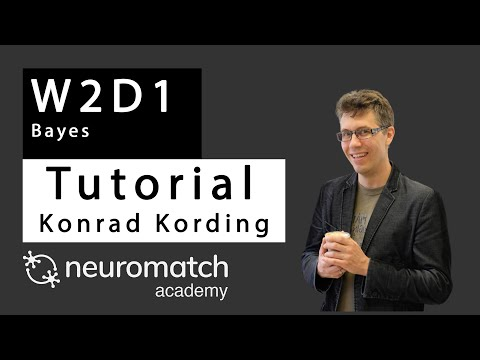

In [4]:
#@title Video 1: Intro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='YSKDhnbjKmA', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


![Generative model](https://github.com/vincentvalton/figures_NMA_W2D1_T3/blob/master/Drawing%20Generative%20Model%20W2T3.png?raw=true)

Here is a graphical representation of the generative model:

  1. We present a stimulus $x$ to participants. 
  2. The brain encodes this true stimulus $x$ noisily (this is the brain's representation of the true visual stimulus: $p(\tilde x|x)$.
  3. The brain then combine this brain encoded stimulus (likelihood: $p(\tilde x|x)$) with prior information (the prior: $p(x)$) to make up the brain's estimated position of the true visual stimulus, the posterior: $p(x|\tilde x)$. 
  3. This brain's estimated stimulus position: $p(x|\tilde x)$, is then used to make a response:  $\hat x$, which is the participant's noisy estimate of the stimulus position (the participant's percept). 
  
Typically the response $\hat x$ also includes some motor noise (noise due to the hand/arm move being not 100% accurate), but we'll ignore it in this tutorial and assume there is no motor noise.



We will use the same experimental setup as in [tutorial 2](https://colab.research.google.com/drive/15pbgrfGjSKbUQoX51RdcNe3UXb4R5RRx#scrollTo=tF5caxVGYURh) but with slightly different probabilities. This time, participants are told that they need to estimate the sound location of a puppet that is hidden behind a curtain. The participants are told to use auditory information and are also informed that the sound could come from 2 possible causes: a common cause (95% of the time it comes from the puppet hidden behind the curtain at position 0), or an independent cause (5% of the time the sound comes from loud-speakers at more distant locations).

---
# Section 1: Likelihood array
    
First, we want to create a likelihood, but for the sake of visualization we will create multiple likelihoods $\tilde x$ (one for each true stimumulus position: $x$). We will then be able to visualize the likelihood as a function of various true stimulus positions: $x$.

We now want to create a likelihood $\tilde x$ for each value of the true stimulus position $x$. To do so we will stack each likelihood vertically for each true stimulus position $x$. We will end up with a 2D array where each row represents a different brain encoding of the stimulus position ($\tilde x$). 

  Using the equation for the un-normalized Gaussian `my_gaussian` and the values in `hypothetical_stim`:
* Create a Gaussian likelihood with mean varying from `hypothetical_stim`, keeping $\sigma_{likelihood}$ constant at 1.
* Each likelihood with a different mean will make up a different row-likelihood of your 2D array, such that you end up with a likelihood array made up of 1,000 row-Gaussians with different means. (_Hint_: `np.tile` won't work here. You may need a for-loop).
* Plot the array using the function `plot_myarray()` already pre-written and commented-out in your script

###Exercise 1. Implement the auditory likelihood as a function of true stimulus position

In [5]:
x = np.arange(-10, 10, 0.1)
hypothetical_stim = np.linspace(-8, 8, 1000)

def compute_likelihood_array(x_points, stim_array, sigma=1.):

    # initializing likelihood_array
    likelihood_array = np.zeros((len(stim_array), len(x_points)))

    # looping over stimulus array 
    for i in range(len(stim_array)):
        ########################################################################
        ## Insert your code here to:
        ##      - Generate a likelihood array using `my_gaussian` function, 
        ##        with std=1, and varying the mean using `stim_array` values.
        ##      - normalize
        ## remove the raise below to test your function
        raise NotImplementedError("You need to complete the function!")
        ########################################################################
        likelihood_array[i, :] = ...
        likelihood_array[i, :] = ...  # normalize

    return likelihood_array

# Uncomment following lines to test your code
# likelihood_array = compute_likelihood_array(x, hypothetical_stim)
# plot_myarray(likelihood_array,
#              '$\~x$ : Brain representation of $x$',
#              'Hypothetical True Stimulus $x$',
#              'Sample Likelihood Array : $p(\~x | x)$')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_9e34b2b1.py)

*Example output:*

<img alt='Solution hint' align='left' width=422 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_9e34b2b1_0.png>



---
# Section 2: Causal mixture of Gaussian prior


Video available at https://youtube.com/watch?v=F0IYpUicXu4


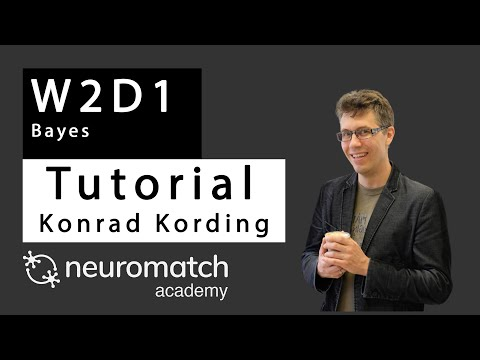

In [7]:
#@title Video 2: Prior array
video = YouTubeVideo(id='F0IYpUicXu4', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


As in Tutorial 2, we want to create a prior that will describe the participants' prior knowledge that sounds come 75% of the time from a common position around the puppet, and 25% of the time from another independent position. We will embody this information into a prior using a mixture of Gaussians. For visualization reasons, we will create a prior that has the same shape (form) as the likelihood array we created in the previous exercise. That is, we want to create a mixture of Gaussian prior as a function the the presented hypothetical stimulus $x$. Since the prior does not change as a function of $x$ it will be identical on each row of the prior 2D array. 

Using the equation for the un-normalised Gaussian `my_gaussian`:
* Generate a Gaussian $Common$ with mean 0 and standard deviation 0.5
* Generate another Gaussian $Independent$ with mean 0 and standard deviation 10
* Combine the two Gaussians (Common + Independent) to make a new prior by mixing the two Gaussians with mixing parameter $p_{independent}$ = 0.05. Make it such that the peakier Gaussian has 95% of the weight (don't forget to normalize afterwards)
* This will be the first row of your prior 2D array
* Now repeat for varying hypoethtical stimuli $x$. Since the prior does not depend on $x$ you can just repeat the prior for each hypothetical $x$ (hint: use np.tile) that row prior to make an array of 1,000 (i.e. `hypothetical_stim.shape[0]`)  row-priors.
* Plot the matrix using the function `plot_myarray()` already pre-written and commented-out in your script

### Exercise 2: Implement the prior array

In [8]:
x = np.arange(-10, 10, 0.1)

def calculate_prior_array(x_points, stim_array, p_indep, 
                          prior_mean_common=.0, prior_sigma_common=.5,
                          prior_mean_indep=.0, prior_sigma_indep=10):
    """
        'common' stands for common
        'indep' stands for independent 
    """

    prior_common = my_gaussian(x_points, prior_mean_common, prior_sigma_common)
    prior_indep = my_gaussian(x_points, prior_mean_indep, prior_sigma_indep)

    ############################################################################
    ## Insert your code here to:
    ##      - Create a mixture of gaussian priors from 'prior_common'
    ##        and 'prior_indep' with mixing parameter 'p_indep'
    ##      - normalize
    ##      - repeat the prior array and reshape it to make a 2D array
    ##        of 1000 rows of priors (Hint: use np.tile() and np.reshape())
    ## remove the raise below to test your function
    raise NotImplementedError("You need to complete the function!")
    ############################################################################
    
    prior_mixed = ...
    prior_mixed = ... # normalize
    
    prior_array = np.tile(...).reshape(...)
    return prior_array

p_independent=.05
# Uncomment following lines, once the task is complete.
# prior_array = calculate_prior_array(x, hypothetical_stim, p_independent)
# plot_myarray(prior_array,
#              'prior: p(x)', 'Hypothetical True Stimulus x',
#              'Prior as a fcn x : p(x)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_89e387f7.py)

*Example output:*

<img alt='Solution hint' align='left' width=421 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_89e387f7_0.png>



---
# Section 3: Bayes rule and Posterior array

Video available at https://youtube.com/watch?v=HpOzXZUKFJc


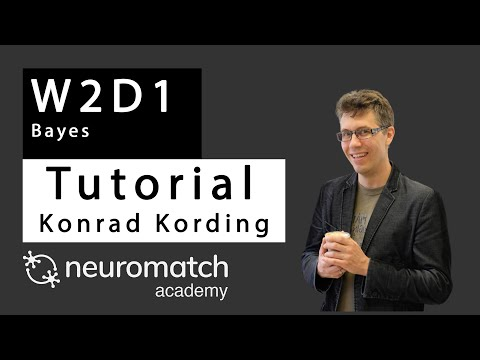

In [10]:
#@title Video 3: Posterior array
video = YouTubeVideo(id='HpOzXZUKFJc', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

We now want to calcualte the posterior using *Bayes Rule*. Since we have already created a likelihood and a prior for each hypothetical stimulus x, all we need to do is to multiply them row-wise. That is, each row of the posterior array will be the posterior resulting from the multiplication of the prior and likelihood of the same equivalent row.

Mathematically:

\begin{eqnarray}
    Posterior\left[i, :\right] \propto Likelihood\left[i, :\right] \odot Prior\left[i, :\right]
\end{eqnarray}

where $\odot$ represents the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e., elementwise multiplication) of the corresponding prior and likelihood row vectors `i` from each matrix.

Follow these steps to build the posterior as a function of the hypoethtical stimulus $x$:
* For each row of the prior and likelihood (i.e. each hypothetical $x$), fill in the posterior matrix so that every row of the posterior array represents the posterior density for a different hypothetical $x$.
* Plot the array using the function `plot_myarray()` already pre-written and commented-out in your script

Optional:
* Do you need to operate on one element--or even one row--at a time? NumPy operations can often process an entire matrix in a single "vectorized" operation. This approach is often much faster and much easier to read than an element-by-element calculation.  Try to write a vectorized version that calculates the posterior without using any for-loops. _Hint_: look at `np.sum` and its keyword arguments.

### Exercise 3: Calculate the posterior as a function of the hypothetical stimulus x

In [11]:
def calculate_posterior_array(prior_array, likelihood_array):

    ############################################################################
    ## Insert your code here to:
    ##      - calculate the 'posterior_array' from the given
    ##        'prior_array', 'likelihood_array'
    ##      - normalize
    ## remove the raise below to test your function
    raise NotImplementedError("You need to complete the function!")
    ############################################################################
    posterior_array = ...
    posterior_array = ... # normalize each row separately

    return posterior_array

# Uncomment following lines, once the task is complete.
# posterior_array = calculate_posterior_array(prior_array, likelihood_array)
# plot_myarray(posterior_array,
#              'posterior: $p(x | \~x)$',
#              'Hypothetical True Stimulus $x$',
#              'Posterior as a fcn of $x$ : $p(x | \~x)$')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_9cdc9264.py)

*Example output:*

<img alt='Solution hint' align='left' width=421 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_9cdc9264_0.png>



---
# Section 4: Estimating the position $\hat x$

Video available at https://youtube.com/watch?v=gy3GmlssHgQ


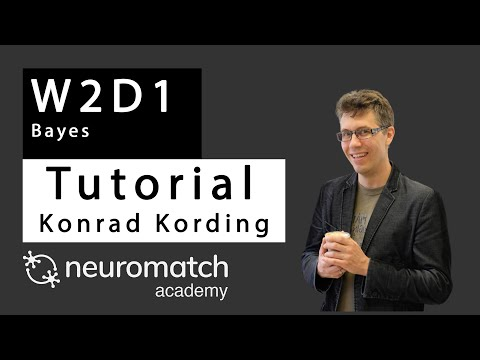

In [13]:
#@title Video 4: Binary decision matrix
video = YouTubeVideo(id='gy3GmlssHgQ', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have a posterior distribution that represents the brain's estimated stimulus position: $p(x|\tilde x)$, we want to make an estimate (response) of the sound location $\hat x$ using the posterior distribution. The participant's noisy estimate of the stimulus position $\hat x$ is the participant's percept. 

This effectively encodes the *decision* that a participant would make for a given hypothetical stimulus $x$. In this exercise, we make the assumptions that participants take the mean of the posterior (decision rule) as a response estimate for the sound location (use the function `moments_myfunc()` provided to calculate the mean of the posterior).

Using this knowledge, we will now represent $\hat x$ as a function of the hypothetical stimulus values $x$. This will result in a 2D binary decision array. To do so, we will scan the posterior matrix (i.e. row-wise), and set the array cell value to 1 at the mean of the row-wise posterior.

**Suggestions**
* For each hypoethetical stimulus $x$ (row of the posterior array), calculate the mean of the posterior, and set the corresponding cell of the binary decision array to 1. (e.g., if the mean of the posterior is at position 0, then set the cell with x_column == 0 to 1).
* Plot the matrix using the function `plot_myarray()` already pre-written and commented-out in your script

### Exercise 4: Calculate the estimated response as a function of the hypothetical stimulus x

In [14]:
def calculate_binary_decision_array(x_points, posterior_array):

    binary_decision_array = np.zeros_like(posterior_array)

    for i in range(len(posterior_array)):

        ########################################################################
        ## Insert your code here to:
        ##      - For each hypothetical stimulus x (row of posterior),
        ##        calculate the mean of the posterior using the povided function 
        ##        `moments_myfunc()`, and set the corresponding cell of the 
        ##        Binary Decision array to 1.
        ##        Hint: you can run 'help(moments_myfunc)' to see the docstring
        ## remove the raise below to test your function
        raise NotImplementedError("You need to complete the function!")
        ########################################################################
        
        mean, _, _ = ... # calculate mean of posterior using 'moments_myfunc'
        idx = ... # find the postion of mean in x_points (closest position)
        binary_decision_array[i, idx] = 1 

    return binary_decision_array

# Uncomment following lines, once the task is complete.
# binary_decision_array = calculate_binary_decision_array(x, posterior_array)
# plot_myarray(binary_decision_array,
#              '$\^x$', 'Hypothetical True Stimulus $x$',
#              'Sample Binary Decision array\n $\^x$ = mean($\~x$)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_d0399098.py)

*Example output:*

<img alt='Solution hint' align='left' width=419 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_d0399098_0.png>



---
# Section 5: Probabilities of encoded stimuli

Video available at https://youtube.com/watch?v=C1d1n_Si83o


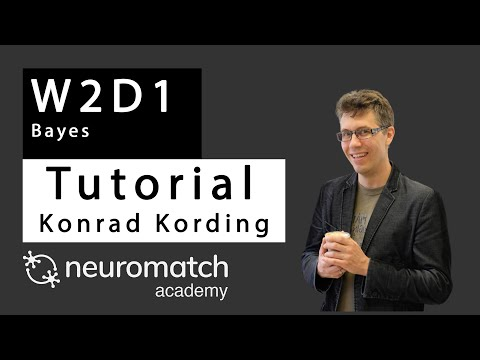

In [16]:
#@title Video 5: Input array
video = YouTubeVideo(id='C1d1n_Si83o', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Because the brain does not have access to the true presented stimulus, we had to compute the binary decision array for hypothetical stimulus values of $x$. We will then use that information when presented with a real stimulus $x$. 

First however, we need to create the input from the true presented stimulus. That is, we will now create a Gaussian centered around the true presented stimulus, with sigma = 1. , and repeat that gaussian distribution across as a function of hypothetical stimulus values x. That is, we want to make a *column* gaussian centered around the true presented stimulus, and repeat this *column* Gaussian across all hypothetical stimulus values $x$.

This, effectively encodes the distribution of the true stimulus (one single simulus) for that a participant and enable us to link the true stimulus $x$, to hypoethetical ones we have already pre-computed. 

**Suggestions**

For this exercise, we will assume the true stimulus is presented at direction -2.5
* Create a Gaussian likelihood with mean = -2.5 and $\sigma$ of 1.
* Make this the first column of your array and repeat that *column* to fill in the true presented stimulus input as a function of hypothetical stimulus locations.
* Plot the array using the function `plot_myarray()` already pre-written and commented-out in your script

###Exercise 5: Generate an input as a function of hypothetical stimulus x

In [17]:
def generate_input_array(x_points, stim_array, posterior_array,
                         mean=-2.5, sigma=1.):

    input_array = np.zeros_like(posterior_array)

    ########################################################################
    ## Insert your code here to:
    ##      - Generate a gaussian centered on the true stimulus -2.5
    ##        and sigma = 1. for each column
    ## remove the raise below to test your function
    raise NotImplementedError("You need to complete the function!")
    ########################################################################
    for i in range(len(x_points)):
        input_array[:, i] = ...
        input_array[:, i] = ... # normalize

    return input_array

# Uncomment following lines, once the task is complete.
# input_array = generate_input_array(x, hypothetical_stim, posterior_array)
# plot_myarray(input_array,
#              'hypothetical stimulus $x$', '$\~x$',
#              'Sample Input Matrix: $p(\~x | x = -2.5)$')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_41daa20a.py)

*Example output:*

<img alt='Solution hint' align='left' width=422 height=280 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_41daa20a_0.png>



---
# Section 6: Normalization and expected estimate distribution

Video available at https://youtube.com/watch?v=5alwtNS4CGw


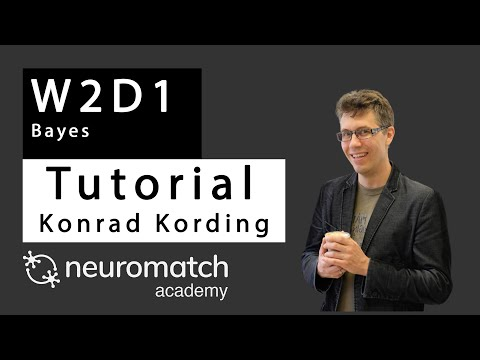

In [19]:
#@title Video 6: Marginalization
video = YouTubeVideo(id='5alwtNS4CGw', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have a true stimulus $x$ and a way to link it to hypothetical stimulus locations, we will be able to estimate what is the brain's representation of the true stimulus $x$ by integrating over all the possible hypothetical stimulus locations that the brain could have been expecting. This is because the brain does not have access to the true stimulus $x$, and as a result we need to integrate over all possible hypothetical values of $x$ it could have expected. 

To integrate over all possible hypothetical values of $x$ we marginalize, that is, we first compute the dot-product from the true presented stimulus and our binary decision array and then sum over x. 

Mathematically, this means that we want to compute:

\begin{eqnarray}
    Marginalization Array = Input Array \odot Binary Decision Array
\end{eqnarray}

\begin{eqnarray}
    Marginal = \int_{x} Marginalization Array
\end{eqnarray}

Since we are performing integration over discreete values using arrays for visualization purposes, the integration reduces to a simple sum over x.

**Suggestions**

* For each row of the input and binary arrays, calculate product of the two and fill in the 2D marginal array.
* Plot the result using the function `plot_myarray()` already pre-written and commented-out in your script
* Calculate and plot the marginal over `x` using the code snippet commented out in your script
   - Note how the limitations of numerical integration create artifacts on your marginal 

###Exercise 6: Implement the marginalization matrix

In [20]:
def my_marginalization(input_array, binary_decision_array):

    ############################################################################
    ## Insert your code here to:
    ##  - Compute 'marginalization_array' by multiplying pointwise the Binary
    ##    decision array over hypothetical stimuli and the Input array
    ##  - Compute 'marginal' from the 'marginalization_array' by summing over x 
    ##    (hint: use np.sum() and only marginalize along the columns)
    ## remove the raise below to test your function
    raise NotImplementedError("You need to complete the function!")
    ############################################################################

    marginalization_array = ...
    marginal = ... # when using np.sum(), be careful about the applied axis
    marginal = ... # normalize

    return marginalization_array, marginal

# Uncomment following lines, once the task is complete.
# marginalization_array, marginal = my_marginalization(input_array, binary_decision_array)
# plot_myarray(marginalization_array, '$x$', '$\^x$', 'Marginalization array: $p(\^x | x)$')
# plt.figure()
# plt.plot(x, marginal)
# plt.xlabel('$\^x$')
# plt.ylabel('probability')
# plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_910a90df.py)

*Example output:*

<img alt='Solution hint' align='left' width=414 height=272 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_910a90df_0.png>

<img alt='Solution hint' align='left' width=416 height=272 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_910a90df_1.png>



---
# Generate some data

Now that we've seen how to calculate the posterior and marginalize to get $p(\hat{x} \mid x)$, we will generate some artificial data for a single participant using the `generate_data()` function provided, and mixing parameter $p_{independent}$ = 0.1. 

Our goal in the next exercise will be to recover that parameter. These parameter recovery experiments are a powerful method for planning and debugging Bayesian analyses--if you cannot recover the given parameters, something has gone wrong!

Please run the code below to generate some synthetic data.  You do not need to edit anything, but check that the plot below matches what you would expect from the video. 

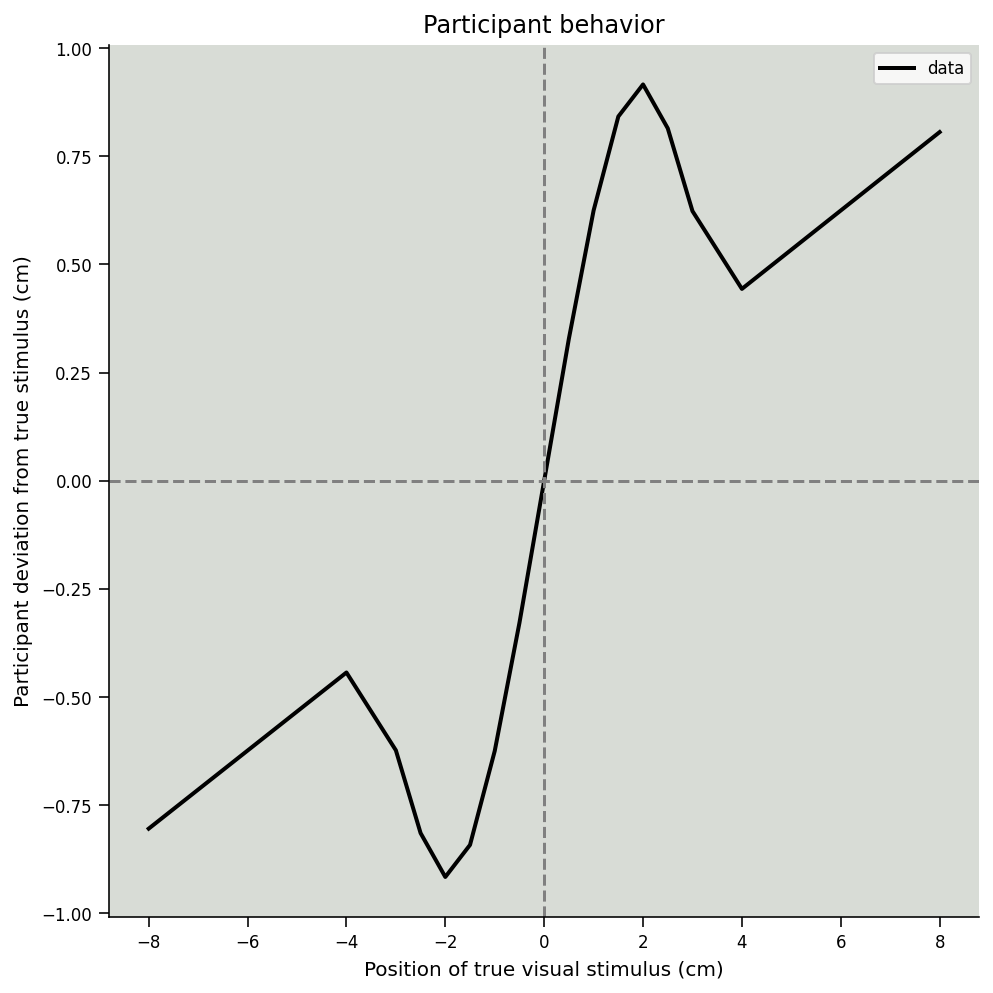

In [22]:
#@title
#@markdown #### Run the 'generate_data' function (this cell)
def generate_data(x_stim, p_independent):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns generated data using the mixture of Gaussian prior with mixture 
  parameter `p_independent`

  Args : 
    x_stim (numpy array of floats) - x values at which stimuli are presented
    p_independent (scalar) - mixture component for the Mixture of Gaussian prior

  Returns:
    (numpy array of floats): x_hat response of participant for each stimulus
  """
  x = np.arange(-10,10,0.1)
  x_hat = np.zeros_like(x_stim)

  prior_mean = 0
  prior_sigma1 = .5
  prior_sigma2 = 3
  prior1 = my_gaussian(x, prior_mean, prior_sigma1)
  prior2 = my_gaussian(x, prior_mean, prior_sigma2)

  prior_combined = (1-p_independent) * prior1 + (p_independent * prior2) 
  prior_combined = prior_combined / np.sum(prior_combined)

  for i_stim in np.arange(x_stim.shape[0]):
    likelihood_mean = x_stim[i_stim]
    likelihood_sigma  = 1
    likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
    likelihood = likelihood / np.sum(likelihood)

    posterior = np.multiply(prior_combined, likelihood)
    posterior = posterior / np.sum(posterior)
    
    # Assumes participant takes posterior mean as 'action'
    x_hat[i_stim] = np.sum(x * posterior)
  return x_hat

# Generate data for a single participant
true_stim = np.array([-8, -4, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 
                      2.5, 3, 4, 8])
behaviour = generate_data(true_stim, 0.10)

plot_simulated_behavior(true_stim, behaviour)

---
#Section 7: Model fitting

Video available at https://youtube.com/watch?v=jbYauFpyZhs


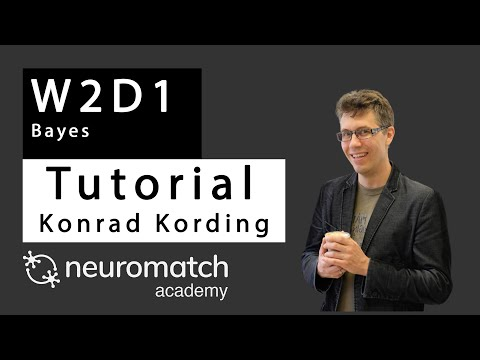

In [23]:
#@title Video 7: Log likelihood
video = YouTubeVideo(id='jbYauFpyZhs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have generated some data, we will attempt to recover the parameter $p_{independent}$ that was used to generate it.

We have provided you with an incomplete function called `my_Bayes_model_mse()` that needs to be completed to perform the same computations you have performed in the previous exercises but over all the participant's trial, as opposed to a single trial.

The likelihood has already been constructed; since it depends  only on the hypothetical stimuli, it will not change. However, we will have to implement the prior matrix, since it depends on $p_{independent}$. We will therefore have to recompute the posterior, input and the marginal in order to get $p(\hat{x} \mid x)$. 

Using $p(\hat{x} \mid x)$, we will then compute the negative log-likelihood for each trial and find the value of $p_{independent}$ that minimizes the negative log-likelihood (i.e. maximises the log-likelihood.  See the model fitting tutorial from W1D3 for a refresher).

In this experiment, we assume that trials are independent from one another. This is a common assumption--and it's often even true! It allows us to define negative log-likelihood as:

\begin{eqnarray}
    -LL = - \sum_i \log p(\hat{x}_i \mid x_i)
\end{eqnarray}

where $\hat{x}_i$ is the participant's response for trial $i$, with presented stimulus $x_i$ 

* Complete the function `my_Bayes_model_mse`, we've already pre-completed the function to give you the prior, posterior, and input arrays on each trial
* Compute the marginalization array as well as the marginal on each trial
* Compute the negative log likelihood using the marginal and the participant's response
* Using the code snippet commented out in your script to loop over possible values of $p_{independent}$


###Exercise 7: Fitting a model to generated data




In [24]:
def my_Bayes_model_mse(params):
    """
    Function fits the Bayesian model from Tutorial 4 
    
    Args : 
        params (list of positive floats):  parameters used by the model 
        (params[0]  = posterior scaling)
                
    Returns :
        (scalar) negative log-likelihood :sum of log probabilities
    """

    # Create the prior array
    p_independent=params[0]
    prior_array = calculate_prior_array(x,
                                        hypothetical_stim,
                                        p_independent, 
                                        prior_sigma_indep= 3.)

    # Create posterior array
    posterior_array = calculate_posterior_array(prior_array, likelihood_array)

    # Create Binary decision array
    binary_decision_array = calculate_binary_decision_array(x, posterior_array)

    # we will use trial_ll (trial log likelihood) to register each trial
    trial_ll = np.zeros_like(true_stim)

    # Loop over stimuli
    for i_stim in range(len(true_stim)):

        # create the input array with true_stim as mean
        input_array = np.zeros_like(posterior_array)
        for i in range(len(x)):
            input_array[:, i] = my_gaussian(hypothetical_stim, true_stim[i_stim], 1)
            input_array[:, i] = input_array[:, i] / np.sum(input_array[:, i])
        
        # calculate the marginalizations
        marginalization_array, marginal = my_marginalization(input_array, 
                                                    binary_decision_array)

        action = behaviour[i_stim]
        idx = np.argmin(np.abs(x - action))

        ########################################################################
        ## Insert your code here to:
        ##      - Compute the log likelihood of the participant
        ## remove the raise below to test your function
        raise NotImplementedError("You need to complete the function!")
        ########################################################################

        trial_ll[i_stim] = ... # Hint: use 'np.finfo(float).eps' to avoid overflow

    neg_ll = - trial_ll.sum()

    return neg_ll

# Uncomment following lines, once the task is complete.
# plot_my_bayes_model(my_Bayes_model_mse)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial3_Solution_4dc32c4b.py)

*Example output:*

<img alt='Solution hint' align='left' width=416 height=272 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial3_Solution_4dc32c4b_0.png>



# Section 8: Summary

Video available at https://youtube.com/watch?v=F5JfqJonz20


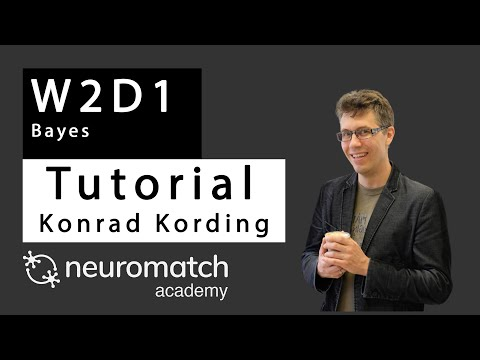

In [26]:
#@title Video 8: Outro
video = YouTubeVideo(id='F5JfqJonz20', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Congratuations! You found $p_{independent}$, the parameter that describes how much weight subjects assign to the same-cause vs. independent-cause origins of a sound. In the preceeding notebooks, we went through the entire Bayesian analysis pipeline:

*   developing a model
*   simulating data, and
*   using Bayes' Rule and marginalization to recover a hidden parameter from the data

This example was simple, but the same princples can be used to analyze datasets with many hidden variables and complex priors and likelihoods. Bayes' Rule will also play a cruical role in many of the other techniques you will see later this week. 

---

If you're still intrigued as to why we decided to use the mean of the posterior as a decision rule for a response $\hat{x}$, we have an extra [(Bonus) tutorial 4](https://colab.research.google.com/drive/1bRENTJSvP4fHBs65_4PNRSTgTNWbT7Qk#scrollTo=LqkrbIEeyqVl) which goes through the most common decision rules and how these rules correspond to minimizing different cost functions.